### https://medium.com/@quantclubiitkgp/stock-buy-sell-hold-prediction-using-cnn-ee7b671f4ad3

In [1]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
company_code = 'WMT'
Dataset_dir = 'stock_history'
work_type = 'stock_cnn_blog_pub-master'
root_path = Path(os.getcwd())
dataset_path = os.path.join(root_path, work_type, Dataset_dir, company_code, company_code + ".csv")

In [7]:
dataset_path

'D:\\git_repos\\AI_NLP_Journey\\CNN Timeseries to Image classification\\stock_cnn_blog_pub-master\\stock_history\\WMT\\WMT.csv'

In [3]:
df =pd.read_csv(dataset_path)

In [4]:
df.drop(columns=['dividend_amount', 'split_coefficient'], inplace=True)
df

,timestamp,open,high,low,close,adjusted_close,volume
0,2020-01-10,117.24,117.340,115.9800,116.38,116.3800,6054752
1,2020-01-09,116.15,117.370,116.0806,117.36,117.3600,5563504
2,2020-01-08,116.30,116.730,115.6800,116.16,116.1600,5875310
3,2020-01-07,117.26,117.515,116.2000,116.56,116.5600,6849343
4,2020-01-06,117.40,118.090,116.7700,117.65,117.6500,6438004
...,...,...,...,...,...,...,...
5028,2000-01-14,64.00,65.940,64.0000,64.50,44.7950,6312200
5029,2000-01-13,66.00,66.130,65.0000,65.13,45.2325,5021000
5030,2000-01-12,66.19,66.750,65.0600,65.06,45.1839,4085000
5031,2000-01-11,67.06,67.750,65.6300,66.25,46.0104,4943300


<Axes: >

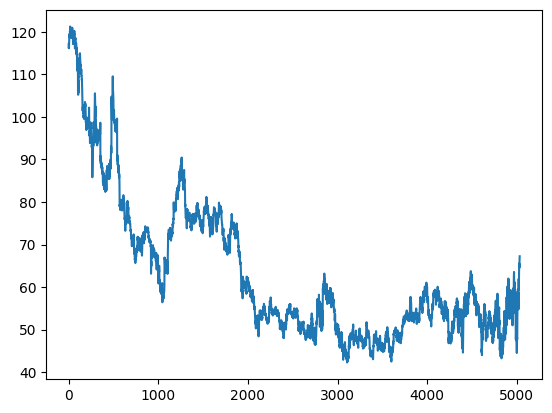

In [5]:
df.close.plot()

In [6]:
df.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume'}, inplace=True)

In [7]:
df

,timestamp,Open,High,Low,Close,adjusted_close,Volume
0,2020-01-10,117.24,117.340,115.9800,116.38,116.3800,6054752
1,2020-01-09,116.15,117.370,116.0806,117.36,117.3600,5563504
2,2020-01-08,116.30,116.730,115.6800,116.16,116.1600,5875310
3,2020-01-07,117.26,117.515,116.2000,116.56,116.5600,6849343
4,2020-01-06,117.40,118.090,116.7700,117.65,117.6500,6438004
...,...,...,...,...,...,...,...
5028,2000-01-14,64.00,65.940,64.0000,64.50,44.7950,6312200
5029,2000-01-13,66.00,66.130,65.0000,65.13,45.2325,5021000
5030,2000-01-12,66.19,66.750,65.0600,65.06,45.1839,4085000
5031,2000-01-11,67.06,67.750,65.6300,66.25,46.0104,4943300


In [8]:
data = df

In [9]:
# Initialize the output DataFrame
indicators_df = data.copy()

# Moving Averages (Simple and Exponential)
for window in [5, 10, 20, 50, 100, 200]:
    indicators_df[f'SMA_{window}'] = indicators_df['Close'].rolling(window=window).mean()
    indicators_df[f'EMA_{window}'] = indicators_df['Close'].ewm(span=window, adjust=False).mean()

# Momentum Indicators
indicators_df['RSI_14'] = 100 - (100 / (1 + (indicators_df['Close'].diff().clip(lower=0).rolling(window=14).mean() / 
                                              indicators_df['Close'].diff().clip(upper=0).abs().rolling(window=14).mean())))

indicators_df['Stochastic_K'] = ((indicators_df['Close'] - indicators_df['Low'].rolling(14).min()) /
                                  (indicators_df['High'].rolling(14).max() - indicators_df['Low'].rolling(14).min())) * 100

indicators_df['Stochastic_D'] = indicators_df['Stochastic_K'].rolling(3).mean()

# Williams %R
indicators_df['Williams_%R'] = ((indicators_df['High'].rolling(14).max() - indicators_df['Close']) /
                                 (indicators_df['High'].rolling(14).max() - indicators_df['Low'].rolling(14).min())) * -100

# Moving Average Convergence Divergence (MACD)
indicators_df['MACD'] = indicators_df['Close'].ewm(span=12, adjust=False).mean() - indicators_df['Close'].ewm(span=26, adjust=False).mean()
indicators_df['MACD_Signal'] = indicators_df['MACD'].ewm(span=9, adjust=False).mean()
indicators_df['MACD_Hist'] = indicators_df['MACD'] - indicators_df['MACD_Signal']

# Average Directional Index (ADX)
high_diff = indicators_df['High'].diff()
low_diff = indicators_df['Low'].diff()
plus_dm = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
minus_dm = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
true_range = pd.DataFrame({
    'hl': indicators_df['High'] - indicators_df['Low'],
    'hc': (indicators_df['High'] - indicators_df['Close'].shift()).abs(),
    'lc': (indicators_df['Low'] - indicators_df['Close'].shift()).abs()
}).max(axis=1)
indicators_df['ATR'] = true_range.rolling(window=14).mean()
indicators_df['Plus_DI'] = 100 * pd.Series(plus_dm).rolling(window=14).mean() / indicators_df['ATR']
indicators_df['Minus_DI'] = 100 * pd.Series(minus_dm).rolling(window=14).mean() / indicators_df['ATR']
indicators_df['ADX'] = 100 * abs(indicators_df['Plus_DI'] - indicators_df['Minus_DI']).rolling(window=14).mean() / (indicators_df['Plus_DI'] + indicators_df['Minus_DI'])

# Commodity Channel Index (CCI)
typical_price = (indicators_df['High'] + indicators_df['Low'] + indicators_df['Close']) / 3
indicators_df['CCI'] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).std())

# Bollinger Bands
indicators_df['Bollinger_Mid'] = indicators_df['Close'].rolling(window=20).mean()
indicators_df['Bollinger_Upper'] = indicators_df['Bollinger_Mid'] + 2 * indicators_df['Close'].rolling(window=20).std()
indicators_df['Bollinger_Lower'] = indicators_df['Bollinger_Mid'] - 2 * indicators_df['Close'].rolling(window=20).std()

# Rate of Change (ROC)
indicators_df['ROC'] = indicators_df['Close'].pct_change(periods=12) * 100

# On-Balance Volume (OBV)
obv = np.where(indicators_df['Close'] > indicators_df['Close'].shift(1), indicators_df['Volume'],
               np.where(indicators_df['Close'] < indicators_df['Close'].shift(1), -indicators_df['Volume'], 0))
indicators_df['OBV'] = obv.cumsum()

# Force Index
indicators_df['Force_Index'] = indicators_df['Close'].diff(1) * indicators_df['Volume']

# Accumulation/Distribution Line (ADL)
adl = ((indicators_df['Close'] - indicators_df['Low']) - (indicators_df['High'] - indicators_df['Close'])) / \
       (indicators_df['High'] - indicators_df['Low']) * indicators_df['Volume']
indicators_df['ADL'] = adl.cumsum()

# Money Flow Index (MFI)
money_flow = typical_price * indicators_df['Volume']
positive_flow = np.where(typical_price > typical_price.shift(1), money_flow, 0)
negative_flow = np.where(typical_price < typical_price.shift(1), money_flow, 0)
mfi_ratio = pd.Series(positive_flow).rolling(14).sum() / pd.Series(negative_flow).rolling(14).sum()
indicators_df['MFI'] = 100 - (100 / (1 + mfi_ratio))

# Accumulation Swing Index (ASI)
indicators_df['ASI'] = ((indicators_df['Close'] - indicators_df['Close'].shift()) +
                        (0.5 * (indicators_df['Close'] - indicators_df['Open'])) +
                        (0.25 * (indicators_df['Close'].shift() - indicators_df['Open'].shift()))) / indicators_df['ATR']

# Chaikin Oscillator
indicators_df['Chaikin_Oscillator'] = indicators_df['ADL'].ewm(span=3, adjust=False).mean() - indicators_df['ADL'].ewm(span=10, adjust=False).mean()


In [10]:
len(indicators_df.columns)

41

In [11]:
indicators_df

,timestamp,Open,High,Low,Close,adjusted_close,Volume,SMA_5,EMA_5,SMA_10,...,Bollinger_Mid,Bollinger_Upper,Bollinger_Lower,ROC,OBV,Force_Index,ADL,MFI,ASI,Chaikin_Oscillator
0,2020-01-10,117.24,117.340,115.9800,116.38,116.3800,6054752,NaN,116.380000,NaN,...,NaN,NaN,NaN,NaN,0,NaN,-2.493133e+06,NaN,NaN,0.000000e+00
1,2020-01-09,116.15,117.370,116.0806,117.36,117.3600,5563504,NaN,116.706667,NaN,...,NaN,NaN,NaN,NaN,5563504,5452233.92,2.984075e+06,NaN,NaN,1.742748e+06
2,2020-01-08,116.30,116.730,115.6800,116.16,116.1600,5875310,NaN,116.524444,NaN,...,NaN,NaN,NaN,NaN,-311806,-7050372.00,2.480477e+06,NaN,NaN,2.137023e+06
3,2020-01-07,117.26,117.515,116.2000,116.56,116.5600,6849343,NaN,116.536296,NaN,...,NaN,NaN,NaN,NaN,6537537,2739737.20,-6.186556e+05,NaN,NaN,1.117955e+06
4,2020-01-06,117.40,118.090,116.7700,117.65,117.6500,6438004,116.822,116.907531,NaN,...,NaN,NaN,NaN,NaN,12975541,7017424.36,1.527346e+06,NaN,NaN,1.282250e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028,2000-01-14,64.00,65.940,64.0000,64.50,44.7950,6312200,63.988,63.767986,61.665,...,59.4640,66.032725,52.895275,10.483042,-1135417023,-6690932.00,-8.926628e+08,63.411561,-0.059870,-2.831069e+06
5029,2000-01-13,66.00,66.130,65.0000,65.13,45.2325,5021000,64.526,64.221991,62.665,...,59.9175,66.744024,53.090976,10.972909,-1130396023,3163230.00,-8.965285e+08,62.938969,0.089726,-4.018509e+06
5030,2000-01-12,66.19,66.750,65.0600,65.06,45.1839,4085000,64.862,64.501327,63.258,...,60.3205,67.369831,53.271169,18.831050,-1134481023,-285950.00,-9.006135e+08,62.390574,-0.239322,-5.438733e+06
5031,2000-01-11,67.06,67.750,65.6300,66.25,46.0104,4943300,65.300,65.084218,63.689,...,60.7425,68.159930,53.325070,20.170506,-1129537723,5882527.00,-9.026654e+08,69.897731,0.146562,-6.178193e+06


In [12]:
df_processed = indicators_df.dropna().reset_index()

In [13]:
df_processed

,index,timestamp,Open,High,Low,Close,adjusted_close,Volume,SMA_5,EMA_5,...,Bollinger_Mid,Bollinger_Upper,Bollinger_Lower,ROC,OBV,Force_Index,ADL,MFI,ASI,Chaikin_Oscillator
0,199,2019-03-28,97.59,97.87,96.53,97.13,95.7185,8054324,97.322,97.563511,...,100.3810,105.373862,95.388138,-5.174265,-176840075,-3221729.60,-4.209025e+06,25.265668,-0.458143,1.965101e+06
1,200,2019-03-27,98.14,98.86,96.96,97.21,95.7973,8471172,97.326,97.445674,...,100.0655,105.020504,95.110496,-4.283182,-168368903,677693.76,-1.045094e+07,34.374394,-0.337187,-3.765671e+05
2,201,2019-03-26,98.36,98.85,98.03,98.32,96.8912,4946289,97.602,97.737116,...,99.8050,104.535842,95.074158,-2.460317,-163422614,5490380.79,-1.189864e+07,40.510713,0.579112,-1.760919e+06
3,202,2019-03-25,97.80,98.62,97.63,98.17,96.7434,5407425,97.672,97.881411,...,99.5600,104.081798,95.038202,-1.435743,-168830039,-811113.75,-1.140705e+07,40.477841,0.017250,-2.010748e+06
4,203,2019-03-22,98.58,99.53,97.94,98.28,96.8518,6708131,97.822,98.014274,...,99.3555,103.709022,95.001978,-0.415442,-162121908,737894.41,-1.524630e+07,48.021873,0.037140,-3.151734e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4823,5028,2000-01-14,64.00,65.94,64.00,64.50,44.7950,6312200,63.988,63.767986,...,59.4640,66.032725,52.895275,10.483042,-1135417023,-6690932.00,-8.926628e+08,63.411561,-0.059870,-2.831069e+06
4824,5029,2000-01-13,66.00,66.13,65.00,65.13,45.2325,5021000,64.526,64.221991,...,59.9175,66.744024,53.090976,10.972909,-1130396023,3163230.00,-8.965285e+08,62.938969,0.089726,-4.018509e+06
4825,5030,2000-01-12,66.19,66.75,65.06,65.06,45.1839,4085000,64.862,64.501327,...,60.3205,67.369831,53.271169,18.831050,-1134481023,-285950.00,-9.006135e+08,62.390574,-0.239322,-5.438733e+06
4826,5031,2000-01-11,67.06,67.75,65.63,66.25,46.0104,4943300,65.300,65.084218,...,60.7425,68.159930,53.325070,20.170506,-1129537723,5882527.00,-9.026654e+08,69.897731,0.146562,-6.178193e+06


In [131]:
predicted_prices = df_processed.SMA_10.values

In [18]:
def plotting_signal(prices, signal_values):
    # Plot the results
    plt.figure(figsize=(15, 10))
    plt.plot(prices, linewidth=0.6, color='blue', label='Predicted Prices', )
    # plt.plot(df_h4['avg'].values[-length:], color='red', linewidth=0.3, label='Actaul Prices')
    # plt.plot(ema, label='EMA', linestyle='--', color='green', linewidth=0.3)
    plt.scatter(np.arange(len(prices)), np.where(signal_values == 1, prices, np.nan), marker='^', color='g', label='Buy Signal')
    plt.scatter(np.arange(len(prices)), np.where(signal_values == 2, prices, np.nan), marker='v', color='r', label='Sell Signal')

    # Annotate the important points
    # for index, price in important_points:
    #     plt.annotate(f'{price:.5f}', (index, price),
    #                  textcoords="offset points", xytext=(0,10), ha='center', color='blue')

    plt.legend()
    plt.title('Predicted Prices and EMA with Buy/Sell Signals and Important Points')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.show()

In [29]:
def signals_generator(predicted_prices, time_steps, price_diff_new_signal = 0.0030 ):
    # Provided predicted price array
    # predicted_prices = np.array([1.07741435, 1.07797974, 1.07768342, 1.07768771, 1.07819248,
    #                              1.07827098, 1.07808965, 1.07778313, 1.07765595, 1.07710098,
    #                              1.07924897, 1.08013435, 1.0815506, 1.08151388, 1.08143381])

    # Define EMA parameters
    n = time_steps  # Number of periods
    alpha = 2 / (n + 1)

    # Calculate EMA using np.convolve
    ema = np.zeros_like(predicted_prices)
    ema[0] = predicted_prices[0]  # First EMA value is the first price

    for i in range(1, len(predicted_prices)):
        ema[i] = alpha * predicted_prices[i] + (1 - alpha) * ema[i-1]

    # Initialize signals
    signals = np.zeros(len(predicted_prices))

    # Generate signals based on EMA crossover
    for i in range(1, len(predicted_prices)):
        if predicted_prices[i] > ema[i] and predicted_prices[i-1] <= ema[i-1]:
            signals[i] = 1  # Buy signal
        elif predicted_prices[i] < ema[i] and predicted_prices[i-1] >= ema[i-1]:
            signals[i] = 2  # Sell signal
        else:
            signals[i] = 0  # Hold signal
        # Print predicted prices at start, buy/sell signals, and end
        
    start = 0
    end = len(signals) - 1
    important_points = []

    for i in range(len(signals)):
        if i == start or i == end or signals[i] != 0:
            important_points.append((i, predicted_prices[i]))
    
    pip_change_min = price_diff_new_signal        
    # Calculate and print percentage changes
    for j in range(1, len(important_points)):
        index_prev, price_prev = important_points[j - 1]
        index_curr, price_curr = important_points[j]
    #     percent_change = ((price_curr - price_prev) / price_prev) * 100
        pip_change = (price_curr - price_prev)
        if pip_change_min < abs(pip_change):
            # print(f"Change from index {index_prev} to {index_curr}: {pip_change:.4f}")
            pass

        else:
            signals[index_prev] = 0
    #         signals[index_curr] = 0

            
    return signals, np.unique(signals, return_counts=True)

In [38]:
signals, stats = signals_generator(df_processed.SMA_10.values, 30, 3)
stats

(array([0., 1., 2.]), array([4781,   21,   26], dtype=int64))

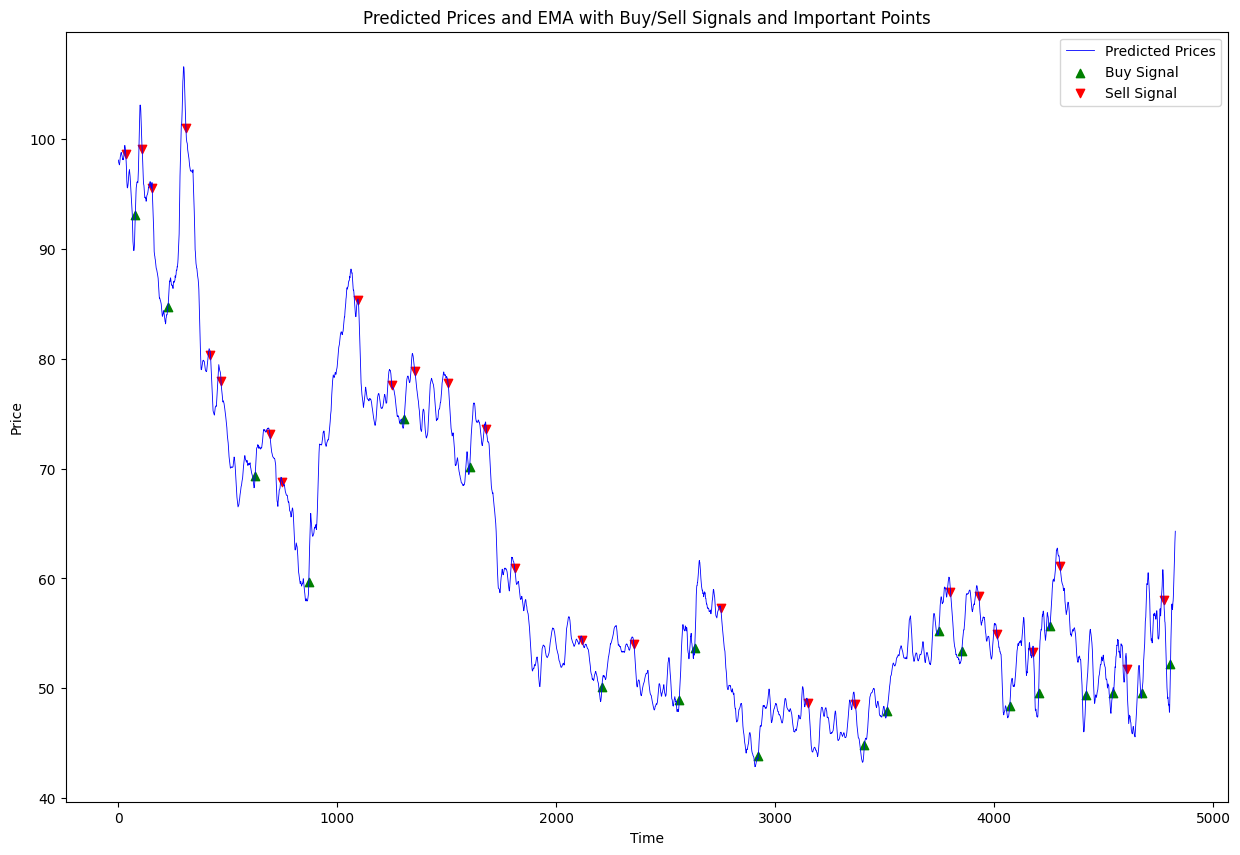

In [39]:
plotting_signal(df_processed.SMA_10.values, signals)

In [41]:
print(len(df_processed.SMA_10.values), len(df_processed), len(signals))

4828 4828 4828


In [44]:
df_processed['labels'] = pd.Series(signals)
df_processed['labels'] = df_processed['labels'].astype(np.int8)
df_processed = df_processed.drop(columns=['index'])

In [45]:
df_processed

,timestamp,Open,High,Low,Close,adjusted_close,Volume,SMA_5,EMA_5,SMA_10,...,Bollinger_Upper,Bollinger_Lower,ROC,OBV,Force_Index,ADL,MFI,ASI,Chaikin_Oscillator,labels
0,2019-03-28,97.59,97.87,96.53,97.13,95.7185,8054324,97.322,97.563511,98.107,...,105.373862,95.388138,-5.174265,-176840075,-3221729.60,-4.209025e+06,25.265668,-0.458143,1.965101e+06,0
1,2019-03-27,98.14,98.86,96.96,97.21,95.7973,8471172,97.326,97.445674,97.868,...,105.020504,95.110496,-4.283182,-168368903,677693.76,-1.045094e+07,34.374394,-0.337187,-3.765671e+05,0
2,2019-03-26,98.36,98.85,98.03,98.32,96.8912,4946289,97.602,97.737116,97.831,...,104.535842,95.074158,-2.460317,-163422614,5490380.79,-1.189864e+07,40.510713,0.579112,-1.760919e+06,0
3,2019-03-25,97.80,98.62,97.63,98.17,96.7434,5407425,97.672,97.881411,97.725,...,104.081798,95.038202,-1.435743,-168830039,-811113.75,-1.140705e+07,40.477841,0.017250,-2.010748e+06,0
4,2019-03-22,98.58,99.53,97.94,98.28,96.8518,6708131,97.822,98.014274,97.670,...,103.709022,95.001978,-0.415442,-162121908,737894.41,-1.524630e+07,48.021873,0.037140,-3.151734e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4823,2000-01-14,64.00,65.94,64.00,64.50,44.7950,6312200,63.988,63.767986,61.665,...,66.032725,52.895275,10.483042,-1135417023,-6690932.00,-8.926628e+08,63.411561,-0.059870,-2.831069e+06,0
4824,2000-01-13,66.00,66.13,65.00,65.13,45.2325,5021000,64.526,64.221991,62.665,...,66.744024,53.090976,10.972909,-1130396023,3163230.00,-8.965285e+08,62.938969,0.089726,-4.018509e+06,0
4825,2000-01-12,66.19,66.75,65.06,65.06,45.1839,4085000,64.862,64.501327,63.258,...,67.369831,53.271169,18.831050,-1134481023,-285950.00,-9.006135e+08,62.390574,-0.239322,-5.438733e+06,0
4826,2000-01-11,67.06,67.75,65.63,66.25,46.0104,4943300,65.300,65.084218,63.689,...,68.159930,53.325070,20.170506,-1129537723,5882527.00,-9.026654e+08,69.897731,0.146562,-6.178193e+06,0


In [50]:
df_processed.columns

Index(['timestamp', 'Open', 'High', 'Low', 'Close', 'adjusted_close', 'Volume',
       'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'SMA_50',
       'EMA_50', 'SMA_100', 'EMA_100', 'SMA_200', 'EMA_200', 'RSI_14',
       'Stochastic_K', 'Stochastic_D', 'Williams_%R', 'MACD', 'MACD_Signal',
       'MACD_Hist', 'ATR', 'Plus_DI', 'Minus_DI', 'ADX', 'CCI',
       'Bollinger_Mid', 'Bollinger_Upper', 'Bollinger_Lower', 'ROC', 'OBV',
       'Force_Index', 'ADL', 'MFI', 'ASI', 'Chaikin_Oscillator', 'labels'],
      dtype='object')

## Explanation of the Script
#### Correlation Matrix: Computes the correlation matrix and removes features that are highly correlated (above a threshold, e.g., 0.85).
#### Lasso: Uses Lasso regression with cross-validation to select features. Lasso shrinks less important feature coefficients to zero.
#### RFE with Random Forest: Performs Recursive Feature Elimination (RFE) with Random Forest to rank and select the top 10 features.
#### Random Forest Importance: Trains a Random Forest and plots the top 10 features based on importance scores.
#### Final Selection: Combines the selected features from Lasso and RFE (can use intersection or union) and creates a reduced dataset X_selected for further modeling.

In [61]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from operator import itemgetter
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

In [62]:
def features_selection(df):
    # Separate features and target variable
    X = df.drop(columns=['labels', 'timestamp'])  # Drop 'timestamp' and target column 'labels'
    y = df['labels']  # Target

    # Ensure that only numeric columns are used for correlation
    X_numeric = X.select_dtypes(include=[np.number])

    # Step 1: Correlation Matrix
    # Remove highly correlated features
    cor_matrix = X_numeric.corr().abs()
    upper_triangle = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.85)]
    X.drop(columns=high_corr_features, inplace=True)
    print(f"Features removed due to high correlation: {high_corr_features}")

    # Step 2: Feature Selection with Lasso
    # Scale the data before Lasso
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply LassoCV for feature selection
    lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, y)
    lasso_selected_features = X.columns[lasso.coef_ != 0]
    print(f"Features selected by Lasso: {list(lasso_selected_features)}")

    # Step 3: Recursive Feature Elimination (RFE) with Random Forest
    rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=10, step=1)
    rfe_selector = rfe_selector.fit(X, y)
    rfe_selected_features = X.columns[rfe_selector.support_]
    print(f"Features selected by RFE: {list(rfe_selected_features)}")

    # Step 4: Feature Importance using Random Forest
    rf = RandomForestClassifier(random_state=0)
    rf.fit(X, y)

    # Combine all selected features
    selected_features = list(set(lasso_selected_features) | set(rfe_selected_features))
    print(f"Final selected features: {selected_features}")
    
    # Define your selection method and topk (number of top features to select)
    selection_method = 'all'  # Options: 'anova', 'mutual_info', 'all'
    topk = 10  # Adjust this number based on your preference for top features

    if selection_method == 'anova' or selection_method == 'all':
        select_k_best_anova = SelectKBest(f_classif, k=topk)
        select_k_best_anova.fit(X, y)

        # Get the selected features by ANOVA
        selected_features_anova = itemgetter(*select_k_best_anova.get_support(indices=True))(list_features)
        print("Selected features by ANOVA:", selected_features_anova)
        print("Indices of selected features by ANOVA:", select_k_best_anova.get_support(indices=True))
        print("****************************************")

    if selection_method == 'mutual_info' or selection_method == 'all':
        select_k_best_mic = SelectKBest(mutual_info_classif, k=topk)
        select_k_best_mic.fit(X, y)

        # Get the selected features by Mutual Information
        selected_features_mic = itemgetter(*select_k_best_mic.get_support(indices=True))(list_features)
        print("Selected features by Mutual Information:", selected_features_mic)
        print("Indices of selected features by Mutual Information:", select_k_best_mic.get_support(indices=True))

    
    return selected_features


In [73]:
from operator import itemgetter
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

def features_selection(df, selection_method='all', topk=10, num_features=225):
    # Separate features and target variable
    X = df.drop(columns=['labels', 'timestamp'])  # Drop non-numeric columns
    y = df['labels']  # Target variable
    
    # Ensure that only numeric columns are used for correlation
    X_numeric = X.select_dtypes(include=[np.number])

    # Step 1: Correlation Matrix
    # Remove highly correlated features
    cor_matrix = X_numeric.corr().abs()
    upper_triangle = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.85)]
    X.drop(columns=high_corr_features, inplace=True)
    print(f"Features removed due to high correlation: {high_corr_features}")

    # Step 2: Feature Selection with Lasso
    # Scale the data before Lasso
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply LassoCV for feature selection
    lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, y)
    lasso_selected_features = X.columns[lasso.coef_ != 0]
    print(f"Features selected by Lasso: {list(lasso_selected_features)}")

    # Step 3: Recursive Feature Elimination (RFE) with Random Forest
    rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=10, step=1)
    rfe_selector = rfe_selector.fit(X, y)
    rfe_selected_features = X.columns[rfe_selector.support_]
    print(f"Features selected by RFE: {list(rfe_selected_features)}")

    # Step 4: Feature Importance using Random Forest
    rf = RandomForestClassifier(random_state=0)
    rf.fit(X, y)

    # Combine Lasso and RFE selected features
    selected_features = list(set(lasso_selected_features) | set(rfe_selected_features))
    print(f"Final selected features from Lasso and RFE: {selected_features}")

    list_features = X.columns.tolist()  # List of all feature names

    # Additional feature selection based on ANOVA and Mutual Information
    if selection_method == 'anova' or selection_method == 'all':
        select_k_best_anova = SelectKBest(f_classif, k=topk)
        select_k_best_anova.fit(X, y)
        selected_features_anova = itemgetter(*select_k_best_anova.get_support(indices=True))(list_features)
        print("Selected features by ANOVA:", selected_features_anova)

    if selection_method == 'mutual_info' or selection_method == 'all':
        select_k_best_mic = SelectKBest(mutual_info_classif, k=topk)
        select_k_best_mic.fit(X, y)
        selected_features_mic = itemgetter(*select_k_best_mic.get_support(indices=True))(list_features)
        print("Selected features by Mutual Information:", selected_features_mic)

    # Find common features if selection_method is 'all'
    if selection_method == 'all':
        common = list(set(selected_features_anova).intersection(selected_features_mic))
        print("Common selected features:", len(common), common)
        
        # Check if enough common features are found
        if len(common) < num_features:
            raise Exception(f'Number of common features found ({len(common)}) < {num_features} required features. Increase "topk" variable.')

        # Get indices of common features
        feat_idx = sorted([list_features.index(c) for c in common][:num_features])
        print("Feature indices for common features:", feat_idx)

    return selected_features, feat_idx

In [74]:
# Usage with topk='all' to select all available features after initial reduction
selected_ftr, f_idx = features_selection(df_processed, selection_method='all', topk='all', num_features=16)



Features removed due to high correlation: ['High', 'Low', 'Close', 'adjusted_close', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'SMA_50', 'EMA_50', 'SMA_100', 'EMA_100', 'SMA_200', 'EMA_200', 'Stochastic_D', 'Williams_%R', 'MACD_Signal', 'CCI', 'Bollinger_Mid', 'Bollinger_Upper', 'Bollinger_Lower', 'OBV']
Features selected by Lasso: ['Open', 'Volume', 'MACD_Hist', 'ATR', 'ADX', 'ASI']
Features selected by RFE: ['Volume', 'Stochastic_K', 'MACD', 'MACD_Hist', 'Plus_DI', 'ADX', 'ROC', 'ADL', 'MFI', 'ASI']
Final selected features from Lasso and RFE: ['ADL', 'MACD_Hist', 'ADX', 'Stochastic_K', 'MFI', 'MACD', 'ASI', 'Open', 'ATR', 'Volume', 'ROC', 'Plus_DI']
Selected features by ANOVA: ('Open', 'Volume', 'RSI_14', 'Stochastic_K', 'MACD', 'MACD_Hist', 'ATR', 'Plus_DI', 'Minus_DI', 'ADX', 'ROC', 'Force_Index', 'ADL', 'MFI', 'ASI', 'Chaikin_Oscillator')
Selected features by Mutual Information: ('Open', 'Volume', 'RSI_14', 'Stochastic_K', 'MACD', 'MACD_Hist', 'ATR', 'Plus_DI', 'Mi

In [70]:
from sklearn.model_selection import train_test_split

In [75]:
# Separate the features and target again from df_processed
X_selected = df_processed[selected_ftr]  # Use only selected features
y = df_processed['labels']  # Define the target variable

# Split the data for model training
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [78]:
# Extract selected features based on indices and ensure only numeric data is selected
X = df_processed.iloc[:, f_idx].select_dtypes(include=[np.number]).values
y = df_processed['labels'].values  # Target variable

# Print total selected features
print('Total number of selected features:', len(selected_ftr))

# Splitting the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=0.8, 
    test_size=0.2, 
    random_state=2, 
    shuffle=True, 
    stratify=y
)

# Uncomment the following lines if you want to handle class imbalance
# smote = RandomOverSampler(random_state=42, sampling_strategy='not majority')
# x_train, y_train = smote.fit_resample(x_train, y_train)
# print('Resampled dataset shape:', Counter(y_train))

# Dynamic train-validation split
train_split = 0.8 if 0.7 * x_train.shape[0] < 2500 else 0.7
print('train_split =', train_split)

# Split the training set further into training and cross-validation sets
x_train, x_cv, y_train, y_cv = train_test_split(
    x_train, y_train, 
    train_size=train_split, 
    test_size=1-train_split, 
    random_state=2, 
    shuffle=True, 
    stratify=y_train
)

# Choose between MinMaxScaler or StandardScaler
scaler = MinMaxScaler(feature_range=(0, 1))  # For Min-Max scaling
# scaler = StandardScaler()                   # For Standard scaling

# Apply scaling to training, cross-validation, and test sets
x_train = scaler.fit_transform(x_train)
x_cv = scaler.transform(x_cv)
x_test = scaler.transform(x_test)

# Copying the main training set for further operations if needed
x_main = x_train.copy()

# Printing the shapes of train, cross-validation, and test sets
print("Shape of x, y train/cv/test:", 
      x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape)


Total number of selected features: 12
train_split = 0.7
Shape of x, y train/cv/test: (2703, 15) (2703,) (1159, 15) (1159,) (966, 15) (966,)


In [65]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from collections import Counter

In [79]:
_labels, _counts = np.unique(y_train, return_counts=True)
print("percentage of class 0 = {}, class 1 = {}".format(_counts[0]/len(y_train) * 100, _counts[1]/len(y_train) * 100))

percentage of class 0 = 99.00110987791344, class 1 = 0.4439511653718091


In [81]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

def get_sample_weights(y):
    """
    Calculate sample weights based on class weights for models with
    imbalanced data and one-hot encoding prediction.

    Parameters:
        y: class labels as integers
    """
    
    y = y.astype(int)  # `compute_class_weight` requires integer labels
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
    
    print("Real class weights are:", class_weights, np.unique(y))
    print("Value counts:", np.unique(y, return_counts=True))
    
    # Assign sample weights based on class weights
    sample_weights = y.copy().astype(float)
    for i, weight in zip(np.unique(y), class_weights):
        sample_weights[sample_weights == i] = weight

    return sample_weights


def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        # print(type(x), type(x_temp), x.shape)
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp

def f1_weighted(y_true, y_pred):
    y_true_class = tf.math.argmax(y_true, axis=1, output_type=tf.dtypes.int32)
    y_pred_class = tf.math.argmax(y_pred, axis=1, output_type=tf.dtypes.int32)
    conf_mat = tf.math.confusion_matrix(y_true_class, y_pred_class)  # can use conf_mat[0, :], tf.slice()
    # precision = TP/TP+FP, recall = TP/TP+FN
    rows, cols = conf_mat.get_shape()
    size = y_true_class.get_shape()[0]
    precision = tf.constant([0, 0, 0])  # change this to use rows/cols as size
    recall = tf.constant([0, 0, 0])
    class_counts = tf.constant([0, 0, 0])

    def get_precision(i, conf_mat):
        print("prec check", conf_mat, conf_mat[i, i], tf.reduce_sum(conf_mat[:, i]))
        precision[i].assign(conf_mat[i, i] / tf.reduce_sum(conf_mat[:, i]))
        recall[i].assign(conf_mat[i, i] / tf.reduce_sum(conf_mat[i, :]))
        tf.add(i, 1)
        return i, conf_mat, precision, recall

    def tf_count(i):
        elements_equal_to_value = tf.equal(y_true_class, i)
        as_ints = tf.cast(elements_equal_to_value, tf.int32)
        count = tf.reduce_sum(as_ints)
        class_counts[i].assign(count)
        tf.add(i, 1)
        return count

    def condition(i, conf_mat):
        return tf.less(i, 3)

    i = tf.constant(3)
    i, conf_mat = tf.while_loop(condition, get_precision, [i, conf_mat])

    i = tf.constant(3)
    c = lambda i: tf.less(i, 3)
    b = tf_count(i)
    tf.while_loop(c, b, [i])

    weights = tf.math.divide(class_counts, size)
    numerators = tf.math.multiply(tf.math.multiply(precision, recall), tf.constant(2))
    denominators = tf.math.add(precision, recall)
    f1s = tf.math.divide(numerators, denominators)
    weighted_f1 = tf.reduce_sum(f.math.multiply(f1s, weights))
    return weighted_f1

def f1_metric(y_true, y_pred):
    """
    this calculates precision & recall 
    """

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # mistake: y_pred of 0.3 is also considered 1
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    # y_true_class = tf.math.argmax(y_true, axis=1, output_type=tf.dtypes.int32)
    # y_pred_class = tf.math.argmax(y_pred, axis=1, output_type=tf.dtypes.int32)
    # conf_mat = tf.math.confusion_matrix(y_true_class, y_pred_class)
    # tf.Print(conf_mat, [conf_mat], "confusion_matrix")

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

get_custom_objects().update({"f1_metric": f1_metric, "f1_weighted": f1_weighted})
sample_weights = get_sample_weights(y_train)
print("Test sample_weights")
rand_idx = np.random.randint(0, 1000, 30)
print(y_train[rand_idx])
print(sample_weights[rand_idx])


Real class weights are: [ 0.33669656 75.08333333 60.06666667] [0 1 2]
Value counts: (array([0, 1, 2]), array([2676,   12,   15], dtype=int64))
Test sample_weights
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.33669656 0.33669656 0.33669656 0.33669656 0.33669656 0.33669656
 0.33669656 0.33669656 0.33669656 0.33669656 0.33669656 0.33669656
 0.33669656 0.33669656 0.33669656 0.33669656 0.33669656 0.33669656
 0.33669656 0.33669656 0.33669656 0.33669656 0.33669656 0.33669656
 0.33669656 0.33669656 0.33669656 0.33669656 0.33669656 0.33669656]


In [82]:
one_hot_enc = OneHotEncoder(sparse=False, categories='auto')  # , categories='auto'
y_train = one_hot_enc.fit_transform(y_train.reshape(-1, 1))
print("y_train",y_train.shape)
y_cv = one_hot_enc.transform(y_cv.reshape(-1, 1))
y_test = one_hot_enc.transform(y_test.reshape(-1, 1))

y_train (2703, 3)


C:\Users\iftek\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [92]:
f_idx

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [91]:
import numpy as np

def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((x.shape[0], img_height, img_width))
    for i in range(x.shape[0]):
        x_temp[i] = np.reshape(x[i], (img_height, img_width))
    return x_temp

# Get number of features and calculate the required dimension
num_features = len(f_idx)
dim = int(np.ceil(np.sqrt(num_features)))  # Smallest integer to fit into a square
padded_size = dim * dim

print(f"Original number of features: {num_features}")
print(f"Calculated padded size for reshaping: {padded_size} ({dim}x{dim})")

# Only pad if the current number of features is less than the padded size
if num_features < padded_size:
    # Debug statement before padding
    print(f"Padding required: Adding {padded_size - num_features} features to match {padded_size}")
    
    # Create padding arrays
    padding_train = np.zeros((x_train.shape[0], padded_size - num_features))
    padding_cv = np.zeros((x_cv.shape[0], padded_size - num_features))
    padding_test = np.zeros((x_test.shape[0], padded_size - num_features))
    
    # Apply padding
    x_train = np.hstack((x_train, padding_train))
    x_cv = np.hstack((x_cv, padding_cv))
    x_test = np.hstack((x_test, padding_test))

# Confirm new shape after padding
print("Shape of x_train after padding:", x_train.shape)
print("Shape of x_cv after padding:", x_cv.shape)
print("Shape of x_test after padding:", x_test.shape)

# Check if the shape matches the expected padded size
expected_size = dim * dim
assert x_train.shape[1] == expected_size, f"x_train has {x_train.shape[1]} features, expected {expected_size}"
assert x_cv.shape[1] == expected_size, f"x_cv has {x_cv.shape[1]} features, expected {expected_size}"
assert x_test.shape[1] == expected_size, f"x_test has {x_test.shape[1]} features, expected {expected_size}"

# Reshape x_train, x_cv, and x_test to (dim, dim)
x_train = reshape_as_image(x_train, dim, dim)
x_cv = reshape_as_image(x_cv, dim, dim)
x_test = reshape_as_image(x_test, dim, dim)

# Add a 1-dimension for channels (3) to simulate RGB channels
x_train = np.stack((x_train,) * 3, axis=-1)
x_cv = np.stack((x_cv,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)

# Final shape confirmation
print("Final shape of x_train:", x_train.shape)
print("Final shape of x_cv:", x_cv.shape)
print("Final shape of x_test:", x_test.shape)
print("Shapes of y_train and y_test:", y_train.shape, y_test.shape)


Original number of features: 16
Calculated padded size for reshaping: 16 (4x4)
Shape of x_train after padding: (2703, 15)
Shape of x_cv after padding: (1159, 15)
Shape of x_test after padding: (966, 15)


AssertionError: x_train has 15 features, expected 16